# WRP - Weight from Regression based Prediction
WRP (pronunciato "WARP") è un modello in grado di predirre il peso di un gatto basandosi su diversi dati come il tipo di alimentazione, dimensioni, sesso, razza e molto altro.

WRP-1 in particolare è una rete neurale molto leggera ed in grado di funzionare senza problemi su sistemi embedded (per es. un Raspberry PI) o su computer con caratteristiiche harware molto limitate.

> [!Come lo sappiamo?]  
> Lo abbiamo **allenato** in una macchina virtuale con solo 3GB di ram disponibili,
> e wrp-1 durante la vase di valutazione ci ha restituito diversi risultati in pochi millisecondi

 


In [18]:
import os
from pathlib import Path
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:

# wrp-1 non accetterà l'input se i dati non sono completi,
# quindi carichiamo tutto il dataset e ignoriamo le righe con dati incompleti
df = pd.read_csv("../data/training_set.csv").dropna()

In [3]:
df.head()

,id_gatto,eta_mesi,razza,sesso,peso_nascita_kg,lunghezza_cm,altezza_spalla_cm,attivita_giornaliera,quantita_cibo_giorno_g,tipo_cibo,pelo_lungo,sterilizzato,temperatura_media_zona,vive_interno,peso_adulto_kg
0,1,108.0,Siamese,Maschio,0.15,52.9,26.1,3.8,126.3,Umido,0,0,27.4,1,7.47
1,2,57.0,Europeo,Maschio,0.09,48.7,24.1,2.0,90.2,Secco,0,1,19.8,1,6.32
2,3,98.0,Persiano,Femmina,0.10,55.8,25.9,5.8,93.4,Misto,1,1,8.8,0,7.15
3,4,20.0,Europeo,Femmina,0.13,43.0,27.6,6.4,83.1,Umido,0,1,20.3,0,4.47
4,5,112.0,Persiano,Femmina,0.13,50.3,38.4,5.5,108.7,Misto,1,1,16.9,0,7.14


In [4]:
def preprocess_training_data(df: pd.DataFrame):
    df_clean = df.copy()
    
    # Rimuovi colonne non necessarie
    if 'id_gatto' in df_clean.columns:
        df_clean = df_clean.drop(columns=['id_gatto'])
    
    # Gestisci valori mancanti numerici con la mediana
    numeric_cols = ['eta_mesi', 'peso_nascita_kg', 'lunghezza_cm', 'altezza_spalla_cm', 
                   'attivita_giornaliera', 'quantita_cibo_giorno_g', 'temperatura_media_zona']
    for col in numeric_cols:
        if col in df_clean.columns:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            
    # Gestisci le altre colonne (categoriche, binarie) come preferisci,
    # ad esempio riempiendo con una moda o un valore specifico come 'Unknown' o 0
    
    # Separa le feature (X) dal target (y)
    X = df_clean.drop(columns=['peso_adulto_kg'])
    y = df_clean['peso_adulto_kg']
    
    return X, y

# Applica la pulizia
X, y = preprocess_training_data(df)
del df # non verrà piu usato, quindi possiamo liberare memoria

In [5]:

# Nelle colonne dove i dati sono binari,
# potrebbero essere presenti dei "Si" e "No"
# o il datatype sbagliato, questa funzione si occupa
# di assicurare che il valore in queste colonne sia sempre e solo 0/1
def ensure_binary(col: pd.Series) -> pd.Series:
    binary_map = {
        1: 1,
        0: 0,
        '1': 1,
        '0': 0,
        'Si': 1,
        'No': 0
    }
    return col.map(binary_map)

In [6]:
# Definizione colonne
categorical_columns = ['razza', 'sesso', 'tipo_cibo'] # puramente stringe di testo
binary_columns = ['pelo_lungo', 'sterilizzato', 'vive_interno']  # valori 0/1
numerical_columns = X.columns.drop(categorical_columns + binary_columns).tolist() # valori numerici

# Assicurati che binary_columns abbia solo 0 e 1
for col in binary_columns:
    X[col] = ensure_binary(X[col])



### Preprocessing
I dati da dare in pasto alla rete neurale **DEVONO** essere tutti numerici.  
Questo perchè una rete neurale, sotto sotto è una funzione matematica molto complicata, 
possiamo pensarla come se fosse `y = f(x)` dove `x` è il nostro input e `y` è il valore che volgiamo prevedere.
Siccome calcolando il valore della funzione non possiamo determinare `y` se non sappiamo `x`, dobbiamo trovare il modo di rendere le nostre parole delle coordinate (trasformarle in numeri) per poi metterle nella funzione al posto di `x` e calcolare il valore di `y`.

Per trasformare questi dati possiamo usare diverse tecniche per i diversi tipi di dati che ci troviamo:

tipo di dato | funzione di trasformazione | come funziona
--- | --- | ---
numerici | StandardScaler() | Normalizza tutti i dati in un formato standard facile da processare per il modello
binari | 'passthrough' | I dati binari sono gia stati processati quando li caricavamo, quindi `passthrough` fa si che rimangano intatti
parole (categorical data) | OneHotEncoder() | Questo espande i nostri dati in ingresso aggiungendo 1 colonna per ogni valore possibile (es per ogni razza), e mette true e false (1 e 0) nelle colonne corrispettive (quindi se un gatto è Siamese, avrà 1 sulla colonna `Siamese` e 0 su tutte le altre colonne che rappresentano la razza del gatto) 


In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('bin', 'passthrough', binary_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

X_processed = preprocessor.fit_transform(X)
y = y.values

In [8]:
X_processed.shape # 4869 gatti, con 22 colonne (dati processati) per ogni gatto

(4869, 22)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2)

In [10]:
# Costruzione della rete neurale
model = Sequential([
    Input(shape=(X_processed.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1)  # peso del gatto)
], name="wrp-1")

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss = 'mse',
    metrics = ['mae']
)

2025-07-30 12:25:17.795996: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=1e-1,
            patience=10,
            min_lr=1e-6
        )
    ],
)

Epoch 1/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 9.2341 - mae: 1.6318 - val_loss: 0.5062 - val_mae: 0.6043 - learning_rate: 0.0010
Epoch 2/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.4457 - mae: 0.9983 - val_loss: 0.6569 - val_mae: 0.6895 - learning_rate: 0.0010
Epoch 3/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6202 - mae: 0.9363 - val_loss: 0.6513 - val_mae: 0.7248 - learning_rate: 0.0010
Epoch 4/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6242 - mae: 0.8797 - val_loss: 0.4538 - val_mae: 0.5571 - learning_rate: 0.0010
Epoch 5/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5838 - mae: 0.9946 - val_loss: 0.7353 - val_mae: 0.7550 - learning_rate: 0.0010
Epoch 6/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9804 - mae: 0.9367 - val_loss: 0.4374 - val_mae: 0.5576 - learning_rate: 0.0010
Epoch 7/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5755 - mae: 0.8389 - val_loss: 0.3237 - val_mae: 0.4716 - learning_rate: 0.0010

In [12]:
# valutazione 
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

Test Loss (MSE): 0.1040
Test MAE: 0.2555


In [13]:
# Predizione di esempio
predictions = model.predict(X_test[:5])
print("Predizioni vs Valori reali:")
for i in range(5):
    print(f"Predetto: {predictions[i][0]:.2f} kg, Reale: {y_test[i]:.2f} kg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predizioni vs Valori reali:
Predetto: 7.40 kg, Reale: 7.14 kg
Predetto: 5.17 kg, Reale: 4.98 kg
Predetto: 4.81 kg, Reale: 4.86 kg
Predetto: 5.37 kg, Reale: 5.70 kg
Predetto: 6.56 kg, Reale: 6.54 kg


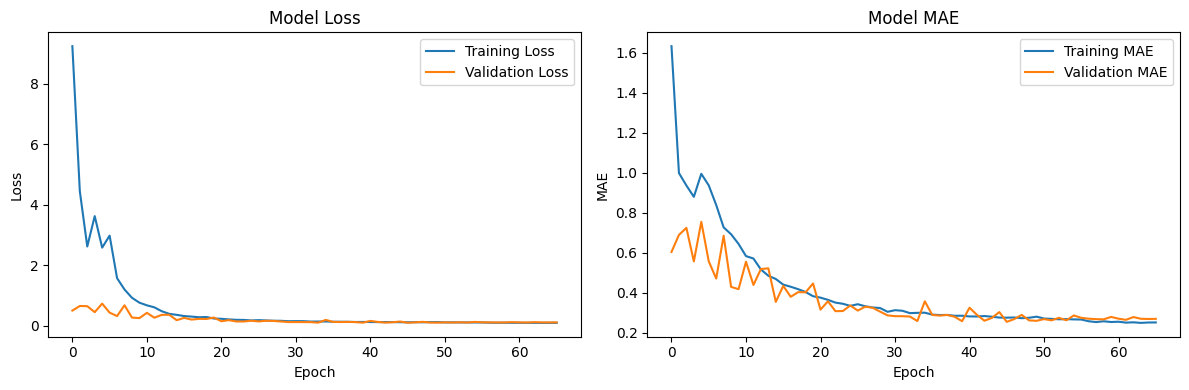

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Risultati
Come possiamo osservare, sia la `training loss` che la `validation loss` scendono ad un buon ritmo fino a raggiungere un plateau intorno a `0.1040` per `MeanSquaredError` e `0.2555` per `MeanAbsoluteError`.

Questo significa che in media `wrp-1` è in grado di predirre il peso del gatto con circa **250 grammi di errore**.

Questi risultati sono molto promettenti tenendo conto della dimensione molto ridotta del modello, ma c'è ancora margine di miglioramento.

In [16]:
# Architettura del modello
model.summary()

Model: "wrp-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,997 (582.02 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,332 (388.02 KB)

In [ ]:
class DataEncoder:
    """Helper che permette di processare i dati in entrata con una sola chamata a funzione"""

    def __init__(self, preprocessor: ColumnTransformer | None = None):
        self.preprocessor: ColumnTransformer = preprocessor or self._create_preprocessor()

    def __call__(self, df: pd.DataFrame):
        return self.process(df)

    def process(self, df: pd.DataFrame, adjust_columns: bool = False):
        features, ids = self._preprocess_data(df)
        X_processed = self.preprocessor.transform(features)

        if adjust_columns:
            # Se ci sono meno features, aggiungiamo zeri,
            # se ce ne sono troppe, tronchiamo i dati
            # (Nota: meglio non usare questa funzionalità se non costretti,
            # visto che il modello otterrà dati fasulli o incompleti)
            
            expected_features = model.input_shape[1]
            actual_features = X_processed.shape[1]
            
            if actual_features < expected_features:
                print(f"⚠️  Padding aggiunto: da {actual_features} a {expected_features} features (risultato potrebbe non esere giusto)")
                # Aggiungi colonne di zeri
                padding = np.zeros((X_processed.shape[0], expected_features - actual_features))
                X_processed = np.hstack([X_processed, padding])
            elif actual_features > expected_features:
                print(f"⚠️  Troncamento: da {actual_features} a {expected_features} features (risultato potrebbe non esere giusto)")
                X_processed = X_processed[:, :expected_features]

        return X_processed, ids

    def _preprocess_data(self, df: pd.DataFrame):
        df_clean = df.copy()
        
        # Rimuovi id_gatto
        if 'id_gatto' in df_clean.columns:
            ids = df_clean['id_gatto'].astype(int)
            df_clean = df_clean.drop(columns=['id_gatto'])
        else:
            ids = range(len(df_clean))
        
        # Gestisci valori mancanti numerici
        numeric_cols = ['eta_mesi', 'peso_nascita_kg', 'lunghezza_cm', 'altezza_spalla_cm', 
                    'attivita_giornaliera', 'quantita_cibo_giorno_g', 'temperatura_media_zona']
        
        for col in numeric_cols:
            if col in df_clean.columns:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                df_clean[col] = df_clean[col].fillna(df_clean[col].median() if not df_clean[col].isna().all() else 0)
        
        # Gestisci valori mancanti binari
        binary_cols = ['pelo_lungo', 'sterilizzato', 'vive_interno']
        for col in binary_cols:
            if col in df_clean.columns:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                df_clean[col] = df_clean[col].fillna(0)
                df_clean[col] = df_clean[col].apply(lambda x: 1 if x == 1 else 0)
        
        # Gestisci categorie sconosciute
        categorical_cols = ['razza', 'sesso', 'tipo_cibo']
        for col in categorical_cols:
            if col in df_clean.columns:
                df_clean[col] = df_clean[col].fillna('Unknown')
                # Converti a stringa per sicurezza
                df_clean[col] = df_clean[col].astype(str)
        
        return df_clean, ids
    
    def _ensure_binary(col: pd.Series) -> pd.Series:
        """
        Nelle colonne dove i dati sono binari,
        potrebbero essere presenti dei "Si" e "No"
        o il datatype sbagliato, questa funzione si occupa
        di assicurare che il valore in queste colonne sia sempre e solo 0/1
        """
        binary_map = {
            1: 1,       0: 0,
            '1': 1,     '0': 0,
            'Si': 1,    'No': 0
        }
        return col.map(binary_map)
    
    def _create_preprocessor(self):
        # Definizione colonne
        categorical_columns = ['razza', 'sesso', 'tipo_cibo'] # puramente stringe di testo
        binary_columns = ['pelo_lungo', 'sterilizzato', 'vive_interno']  # valori 0/1
        numerical_columns = self.df.columns.drop(categorical_columns + binary_columns).tolist() # valori numerici

        # Assicurati che binary_columns abbia solo 0 e 1
        for col in binary_columns:
            self.df[col] = ensure_binary(self.df[col])

        return ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_columns),
                ('bin', 'passthrough', binary_columns),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
            ])

    def _fit_preprocessor(self,df: pd.DataFrame):
        self.preprocessor.fit_transform(df)

encoder = DataEncoder(preprocessor)

['models/wrp-1/wrp-1-encoder.pkl']

In [ ]:
def save_model(model: Sequential, preprocessor: ColumnTransformer, data_encoder: DataEncoder):
    dir_path = Path("..") / "models" / model.name
    model_path = dir_path / (str(model.name) + ".keras")
    preprocessor_path = dir_path / "preprocessor.pkl"
    encoder_path = str(model.name) + "-encoder.pkl"
    os.makedirs(model_path.parent, exist_ok=True)

    model.save(model_path)
    joblib.dump(preprocessor, preprocessor_path)
    joblib.dump(data_encoder,encoder_path)


save_model(model, preprocessor, encoder)

# Come usare `wrp-1`
Come puoi vedere, `wrp-1` richiede diversi step di preprocessing dei dati, per questo abbiamo creato `DataEncoder`, una classe helper che permette di saltare tutta la parte di normalizzazione e filtraggio dei dati e passare direttamente ad utilizzare dati gia processati per prevedere il peso del gatto.

`DataEncoder` viene salvato assieme al modello con il nome `wrp-{versione}-encoder.pkl` e dispone di un metodo `process()` che si occuperà di tutta la parte descritta sopra. 

Esempio di come usare wrp-1 e wrp-1-encoder per determinare il peso di un gatto.  
I risultati verranno salvati in `out/risultati-wrp-1.csv`

In [33]:

model: Sequential = keras.models.load_model("models/wrp-1/wrp-1.keras")
encoder = joblib.load("models/wrp-1/wrp-1-encoder.pkl")

# Carica test set
test_df = pd.read_csv("data/test_set.csv")

try:
    # processa i dati
    X_processed, ids = encoder(test_df)
    
    # determina il peso del gatto
    predictions = model.predict(X_processed)
    
    # Salva risultati
    os.makedirs("out", exist_ok=True)
    with open("out/risultati-wrp-1.csv", "w") as out:
        out.write("id_gatto,peso_previsto_kg\n")
        for id_gatto, peso in zip(ids, predictions):
            out.write(f"{id_gatto},{peso[0]:.2f}\n")

    print("✅ Predizioni completate!")
except Exception as e:
    print(f"❌ Errore finale: {e}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
✅ Predizioni completate!


In [32]:
# Salva anche le colonne per riferimento per il preprocessor (solo per debug)
feature_info = {
    'columns': X.columns.tolist(),
    'categorical': categorical_columns,
    'numerical': numerical_columns,
    'binary': binary_columns
}
joblib.dump(feature_info, 'models/wrp-1/feature_info.pkl')

print("Preprocessor e info salvati correttamente!")

Preprocessor e info salvati correttamente!
